# CLIP‑Based Reward Estimator

This notebook replaces the ResNet reward head with a language‑conditioned CLIP model from **`transformers`**. The scalar reward is the cosine similarity between the current frame and the prompt **"a red Kong dog toy centered in the frame"**. Higher values → Kong is more centered.

In [1]:
import os, random, torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt

from transformers import CLIPProcessor, CLIPModel

import config                                   # project‑level config
from importnb import Notebook
with Notebook():
    from jetbot_dataset import JetbotDataset    # same dataset class as before

device = torch.device(config.DEVICE)
print("Using device ➜", device)

# ----------------------------------------------------------------------
# Load CLIP model (ViT‑B/32 for speed; switch to larger backbone if GPU allows)
# ----------------------------------------------------------------------
MODEL_NAME = "openai/clip-vit-base-patch32"

processor = CLIPProcessor.from_pretrained(MODEL_NAME)
clip_model = CLIPModel.from_pretrained(MODEL_NAME).eval().to(device)

# Pre‑encode the text prompt so we don't waste time each call
PROMPT = "a red Kong dog toy centered in the frame"
with torch.no_grad():
    txt_inputs = processor(text=PROMPT, return_tensors="pt").to(device)
    text_emb = clip_model.get_text_features(**txt_inputs).float()
    text_emb = text_emb / text_emb.norm(p=2, dim=-1, keepdim=True)   # (1,dim)
print("Text embedding ready.")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Using device ➜ cuda


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

C:\Projects\pythonenv-deeprl\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\irvin\.cache\huggingface\hub\models--openai--clip-vit-base-patch32. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Text embedding ready.


C:\Projects\pythonenv-deeprl\Lib\site-packages\transformers\models\clip\modeling_clip.py:546: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


In [2]:
def clip_reward(pil_img):
    """Return a scalar ∈[0,1] where 1 means the red Kong is well‑centered."""
    clip_model.eval()
    with torch.no_grad():
        inputs = processor(images=pil_img, return_tensors="pt").to(device)
        img_emb = clip_model.get_image_features(**inputs).float()
        img_emb = img_emb / img_emb.norm(p=2, dim=-1, keepdim=True)  # (1,dim)
        sim = (img_emb @ text_emb.T).squeeze()                        # cosine ≈‑1…1
        return (sim + 1) / 2                                          # map to 0…1


In [3]:
# ----------------------------------------------------------------------
# Load the JetbotDataset in *exactly* the same way as in the ResNet notebook
# ----------------------------------------------------------------------
IMAGE_SIZE    = config.IMAGE_SIZE
N_PREV_FRAMES = config.NUM_PREV_FRAMES

TRANSFORM = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
])

dataset = JetbotDataset(
    csv_path=config.CSV_PATH,
    data_dir=config.DATA_DIR,
    image_size=IMAGE_SIZE,
    num_prev_frames=N_PREV_FRAMES,
    transform=TRANSFORM,
    seed=42,
)
print("Dataset length:", len(dataset))

Loaded combined CSV with columns: ['session_id', 'image_path', 'timestamp', 'action']
Total rows in CSV: 23081, Valid sequence start indices: 23037
Dataset length: 23037


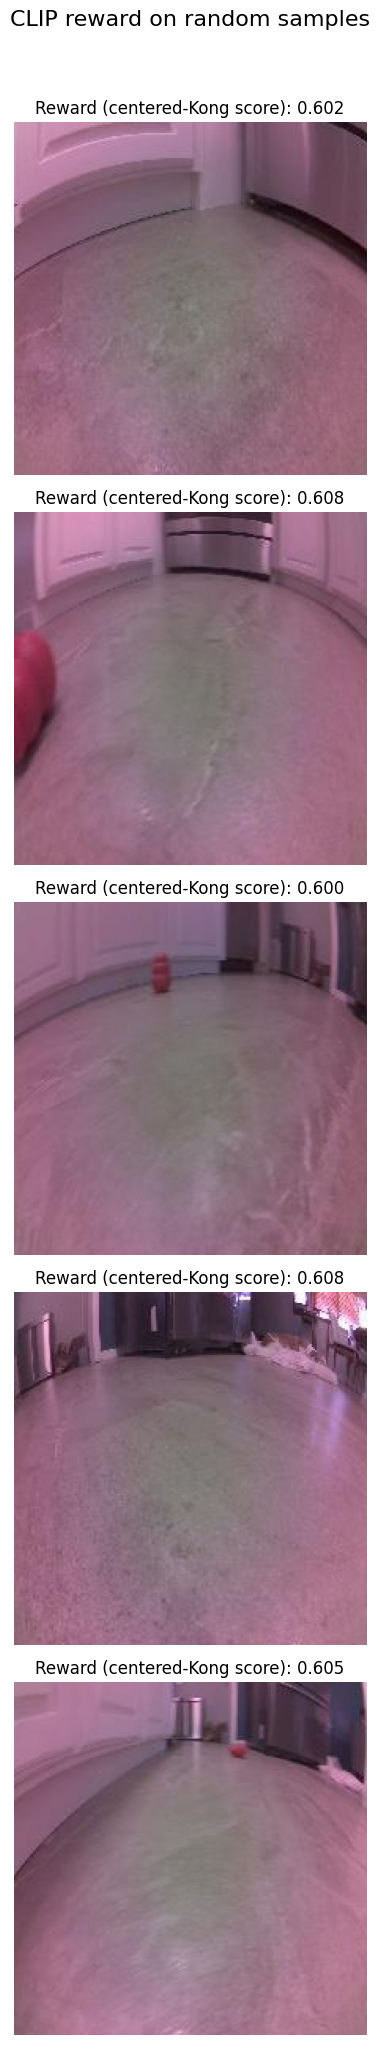

In [4]:
def show_clip_rewards(ds, n=5, title="CLIP reward on random samples"):
    idxs = random.sample(range(len(ds)), n)
    plt.figure(figsize=(8, 4*n))
    for i, idx in enumerate(idxs):
        curr_img, _, _ = ds[idx]           # JetbotDataset returns (curr, r, prev)
        pil_img = T.ToPILImage()(curr_img)
        r = clip_reward(pil_img).item()

        plt.subplot(n, 1, i+1)
        plt.imshow(pil_img)
        plt.axis(False)
        plt.title(f"Reward (centered‑Kong score): {r:.3f}")
    plt.suptitle(title, y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()

show_clip_rewards(dataset, n=5)

## (Optional) Live JetBot loop
Uncomment and adapt the following cell if you want to stream frames from a real JetBot and display the CLIP‑based reward in real time.

In [ ]:
# from jetbot_remote_client import RemoteJetBot
# import ipywidgets as widgets, asyncio, cv2
#
# JETBOT_IP  = "192.168.68.52"          # change to your robot's IP
# REFRESH_HZ = 15
#
# bot = RemoteJetBot(JETBOT_IP)
# print("Connected to JetBot at", JETBOT_IP)
#
# reward_label = widgets.Label(value="Reward: ---")
# display(reward_label)
#
# async def live_loop():
#     while True:
#         bgr = bot.get_frame()
#         if bgr is not None:
#             rgb  = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
#             pil  = Image.fromarray(rgb)
#             r = clip_reward(pil).item()
#             reward_label.value = f"Reward: {r:.3f}"
#         await asyncio.sleep(1 / REFRESH_HZ)
#
# await live_loop()